# Minimum variance portfolio on selected Danish stocks

In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

## Load the data

In [2]:
files_name = [f for f in listdir('..\data\DK') if isfile(join('..\data\DK', f))]
stocks_names = [f.split(',')[0].split('_')[2] for f in files_name] 
danish_stocks_df = [pd.read_csv('..\data\DK\\'+f, sep=',', index_col=0, parse_dates=['time']) for f in files_name]

In [5]:
closes_df = [df['close'].values for df in danish_stocks_df]

In [28]:
min_index = min(range(len(closes_df)), key=lambda i: len(closes_df[i]))
max_index = max(range(len(closes_df)), key=lambda i: len(closes_df[i]))

In [29]:
start_date = danish_stocks_df[min_index].index[0]
end_date = danish_stocks_df[max_index].index[-1]
start_date, end_date

(Timestamp('2016-06-09 09:00:00+0200', tz='UTC+02:00'),
 Timestamp('2023-07-07 09:00:00+0200', tz='UTC+02:00'))

In [20]:
[len(danish_stocks_df[i].loc[start_date:, 'close']) for i in range(len(danish_stocks_df))]

[1764, 1771, 1771, 1771, 1771, 1771, 1771, 1747, 1771, 1771, 1771, 1771, 1771]

In [34]:
pd.date_range(start=start_date, end=end_date, freq='B')

DatetimeIndex(['2016-06-09 09:00:00+02:00', '2016-06-10 09:00:00+02:00',
               '2016-06-13 09:00:00+02:00', '2016-06-14 09:00:00+02:00',
               '2016-06-15 09:00:00+02:00', '2016-06-16 09:00:00+02:00',
               '2016-06-17 09:00:00+02:00', '2016-06-20 09:00:00+02:00',
               '2016-06-21 09:00:00+02:00', '2016-06-22 09:00:00+02:00',
               ...
               '2023-06-26 09:00:00+02:00', '2023-06-27 09:00:00+02:00',
               '2023-06-28 09:00:00+02:00', '2023-06-29 09:00:00+02:00',
               '2023-06-30 09:00:00+02:00', '2023-07-03 09:00:00+02:00',
               '2023-07-04 09:00:00+02:00', '2023-07-05 09:00:00+02:00',
               '2023-07-06 09:00:00+02:00', '2023-07-07 09:00:00+02:00'],
              dtype='datetime64[ns, UTC+02:00]', length=1847, freq='B')

In [27]:
danish_stocks_df[0].loc[start_date:, :].resample('D').mean()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

- [ ] interpolate the arrays (min common data, max common date)

## EDA

In [23]:
returns = [df['close'].pct_change().dropna() for df in danish_stocks_df]

In [34]:
returns_dict = {stock: ret.values for stock, ret in zip(stocks_names, returns)}

In [41]:
returns_dict['AOJ']

array([ 0.01190476,  0.03294118, -0.00911162, ..., -0.00522195,
       -0.01049862,  0.00530505])

In [45]:
mean_returns_dict = {stock: values.mean() for stock, values in returns_dict.items()}

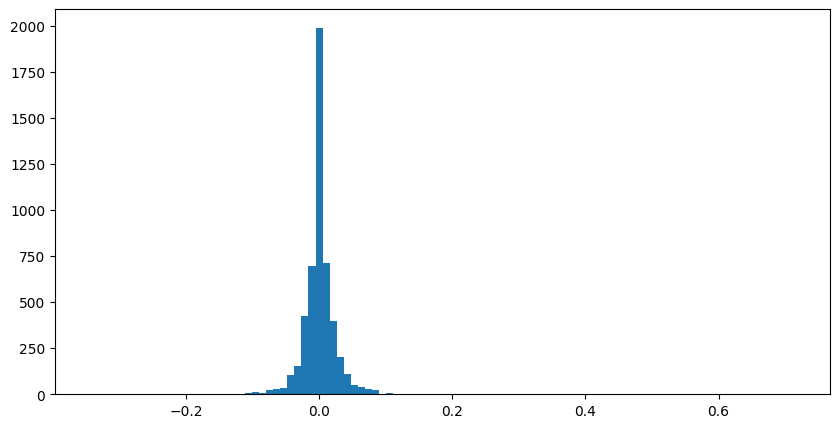

In [44]:
# Visuallize the returns distrubution of AOJ
fig = plt.figure(figsize=(10, 5))
plt.hist(returns_dict['AOJ'], bins=100)
plt.show()

In [53]:
print('Mean return of AOJ: ', mean_returns_dict['AOJ'])
print('Standard deviation of the AOJ\'s returns is: ', returns_dict['AOJ'].std())
print('The skewness of the AOJ\'s returns is: ', skew(returns_dict['AOJ']))
print('The kurtosis of the AOJ\'s returns is: ', kurtosis(returns_dict['AOJ']))

Mean return of AOJ:  0.0009282415464997915
Standard deviation of the AOJ's returns is:  0.02727309487604144
The skewness of the AOJ's returns is:  3.4488053505615333
The kurtosis of the AOJ's returns is:  103.41202873904344


### Correlation of the returns

In [ ]:
returns

In [54]:
# Correlations of the returns
corr_matrix = np.corrcoef(, rowvar=False)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (13,) + inhomogeneous part.